## Stock Price Prediction (SPY)

### Problem Statement

Our goal is to predict the daily adjusted closing prices of SPDR S&P 500 ETF Trust (SPY) using data from the previous 60 days.

### Methodology

We will use a particular kind of artificial recurrent neural network called Long Short Term Memory (LSTM) which is capable of learning long-term dependencies.They are networks with loops in them, allowing information information to flow from one step to the next. LSTM can store past information which is important and forget the information that is not improtant according to weights for forget gates. It is commonly used in text generation, handwriting recognition, music generation, language translation as well as weather or stock price forecast.

### Data

We will use five years of historical prices for SPY from 01/01/2015 to 12/31/2019, which can be easily downloaded from [Yahoo finance](https://finance.yahoo.com/quote/SPY/).  
(2020 data is excluded since pandemic related recession is not experienced frequently in history.)

In [1]:
# Import libraries

import math
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Using TensorFlow backend.


In [2]:
# Read the stock data
spy_df = web.DataReader('SPY', data_source='yahoo', 
                        start='2015-01-01', end='2019-12-31')

### EDA

In [3]:
spy_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,206.880005,204.179993,206.380005,205.429993,121465900.0,185.071075
2015-01-05,204.369995,201.350006,204.169998,201.720001,169632600.0,181.728745
2015-01-06,202.720001,198.860001,202.089996,199.820007,209151400.0,180.017090
2015-01-07,202.720001,200.880005,201.419998,202.309998,125346700.0,182.260269
2015-01-08,206.160004,203.990005,204.009995,205.899994,147217800.0,185.494492
...,...,...,...,...,...,...
2019-12-24,321.519989,320.899994,321.470001,321.230011,20270000.0,319.352142
2019-12-26,322.950012,321.640015,321.649994,322.940002,30911200.0,321.052124
2019-12-27,323.799988,322.279999,323.739990,322.859985,42528800.0,320.972565


In [4]:
# Number of rows and columns in the dataframe
spy_df.shape

(1258, 6)

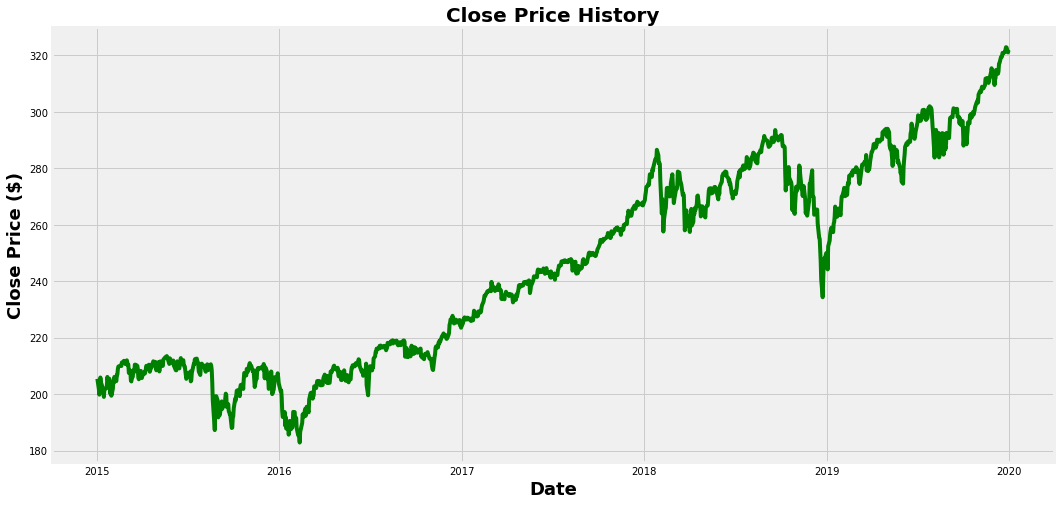

In [51]:
# Plot the closing price history of the stock
plt.figure(figsize=(16,8))
plt.title('Close Price History', fontweight='bold', fontsize=20)
plt.plot(spy_df['Close'], color='green')
plt.xlabel('Date', fontsize=18, fontweight='bold')
plt.ylabel('Close Price ($)', fontsize=18, fontweight='bold')
plt.show()

In [6]:
# Create a new dataframe with only Close column
close_spy_df = spy_df.filter(['Close'])

In [7]:
# Save the price values to a numpy array
close_spy_arr = close_spy_df.values

In [8]:
# Get the length of training data (80% of sample size)
train_size = int(np.round(len(close_spy_arr) * .8))

In [9]:
train_size

1006

### Data Preprocessing

We will use MinMaxScaler estimator to transform the prices such that they are in the given range on the training set (between zero and one inclusive).

In [10]:
# Scale the data
sc = MinMaxScaler(feature_range=(0,1))
close_spy_arr_scaled = sc.fit_transform(close_spy_arr)

close_spy_arr_scaled

array([[0.16112216],
       [0.13463735],
       [0.12107372],
       ...,
       [0.99942878],
       [0.98672176],
       [0.99229   ]])

In [11]:
# Create the scaled train data set
train_scaled = close_spy_arr_scaled[0:train_size, :]

In [12]:
train_scaled

array([[0.16112216],
       [0.13463735],
       [0.12107372],
       ...,
       [0.46551974],
       [0.46323528],
       [0.47872642]])

In [13]:
# Create x_train_scaled y_train_scaled data sets

x_train_scaled = [] # empty list
y_train_scaled = [] # empty list

for i in range(60, len(train_scaled)):
    x_train_scaled.append(train_scaled[i-60:i, 0]) # previous 60 days of values
    y_train_scaled.append(train_scaled[i, 0]) # target value    

In [14]:
# Print first values from both x_train_scaled and y_train_scaled
# First 60 days values (feature) & 61th day value (target)
x_train_scaled[0], y_train_scaled[0]

(array([0.16112216, 0.13463735, 0.12107372, 0.13884921, 0.16447739,
        0.15269845, 0.14127636, 0.13720732, 0.128498  , 0.11536267,
        0.13399489, 0.13706451, 0.14434609, 0.16590523, 0.15783838,
        0.16126496, 0.14191894, 0.12335807, 0.13656485, 0.1184323 ,
        0.13606509, 0.1569103 , 0.15134207, 0.16604793, 0.16197888,
        0.15541122, 0.17097371, 0.17183032, 0.18603653, 0.19217588,
        0.19453169, 0.1946745 , 0.19360362, 0.20259855, 0.20238439,
        0.20666759, 0.20538267, 0.20359797, 0.19845804, 0.20795263,
        0.20174182, 0.19538831, 0.19703031, 0.17589948, 0.18203883,
        0.15790973, 0.15448315, 0.17304401, 0.16397773, 0.18360937,
        0.17918337, 0.19703031, 0.19017703, 0.19667335, 0.19374642,
        0.18532272, 0.16347797, 0.15998004, 0.16333527, 0.18125356]),
 0.168260934875319)

In [15]:
# Convert x_train_scaled and y_train_scaled lists to numpy arrays
x_train_scaled,y_train_scaled = np.array(x_train_scaled),np.array(y_train_scaled)

In [16]:
# Reshape the train data as 3-dimensional array
x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], x_train_scaled.shape[1], 1))

In [17]:
# Build the LSTM network
model = Sequential()
model.add(LSTM(units=50, 
               return_sequences=True, 
               input_shape=(x_train_scaled.shape[1],1)))
# Add dropout with a probability of 0.5
model.add(Dropout(.5)) 
model.add(LSTM(units=50,
               return_sequences=False))
# Add dropout with a probability of 0.5
model.add(Dropout(.5)) 
model.add(Dense(25))
model.add(Dense(1))

In [19]:
# Compile and fit the LSTM network
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_scaled, y_train_scaled, epochs=10,   
          batch_size=1, verbose=-1)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [35]:
# Create the scaled test data set (20% of the sample size)
test_scaled = close_spy_arr_scaled[train_size - 60:, :]

In [36]:
# Create x_test_scaled y_test data sets

x_test_scaled = [] # empty list
y_test = close_spy_arr[train_size:, :] # unscaled array

for i in range(60, len(test_scaled)):
    x_test_scaled.append(test_scaled[i-60:i, 0]) # previous 60 days of values  

In [37]:
# Convert the data to a numpy array
x_test_scaled = np.array(x_test_scaled)

In [38]:
# Reshape the data
x_test_scaled = np.reshape(x_test_scaled, 
                           (x_test_scaled.shape[0], 
                            x_test_scaled.shape[1], 1))

In [39]:
# Predict the price values
preds = model.predict(x_test_scaled)
preds = sc.inverse_transform(preds)

In [41]:
# Calculate RMSE
rmse =np.sqrt(np.mean(((preds - y_test)**2)))
rmse

8.388251442610185

c:\users\sibel\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


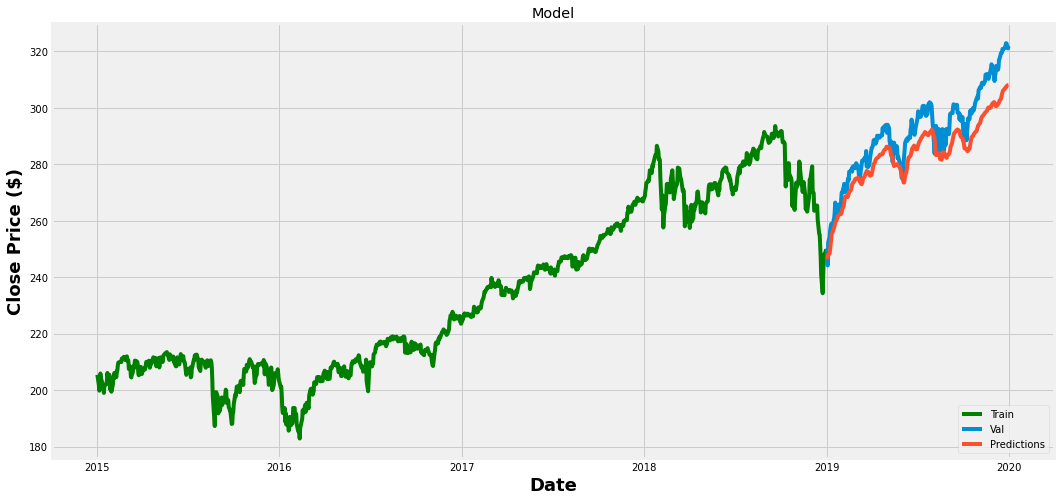

In [57]:
# Plot the actual values vs predictions
train = close_spy_df[:train_size]
valid = close_spy_df[train_size:]
valid['Predictions'] = preds

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18, fontweight='bold')
plt.ylabel('Close Price ($)', fontsize=18, fontweight='bold')
plt.plot(train['Close'], color='green')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [50]:
# Display actual prices vs predictions
valid

,Close,Predictions
Date,,
2019-01-02,250.179993,246.363998
2019-01-03,244.210007,247.637589
2019-01-04,252.389999,247.618759
2019-01-07,254.380005,248.539429
2019-01-08,256.769989,250.013275
...,...,...
2019-12-24,321.230011,307.008759
2019-12-26,322.940002,307.277924
2019-12-27,322.859985,307.706238


It looks like the model is pretty decent predicting stock market prices based on past 60 days values.

Question: Can we rely on a robust LSTM network when making investment decisions?